#프로젝트 소스코드

사용되는 package에 대한 선언

In [7]:
import matplotlib.pyplot as plt
import glob
import cv2
import numpy as np
import pandas as pd
import tensorflow as tf
from sklearn.model_selection import train_test_split


##DATA 전처리

데이터의 전처리 과정
1. 라벨별 폴더가 있는 path와 label의 수, 변환할 이미지 크기를 인자로 받으며 각 폴더별로 이미지를 읽는다.
2. 이미지는 openCV를 사용해서 읽는다. 그리고 openCV는 이미지를 BGR채널로 읽고 matplotlib은 RGB 채널로 이미지를 표시하기 때문에, matplotlib을 사용하기 위해서 BGR채널을 RGB로 변환해주는 작업을 해줍니다.
3. 이미지의 크기를 일정한 크기로 변환해줍니다. 보통 사이즈를 줄일 때에는 보간법(interpolation으로 cv2.INTER_AREA를 많이 사용하고, 사이즈를 키울 때에는 cv2.INTER_CUBIC을 많이 사용합니다.
4. 폴더별로 이미지를 읽고 있기 때문에 같은 폴더 내에는 동일한 라벨로 설정해줍니다.(각 라벨별 확률로 output y를 설정합니다.)
5. x_train, y_train을 numpy array로 변환해서 반환합니다.

In [8]:
N_CLASSES = 43
RESIZED_IMAGE = (32, 32, 3)

def read_trainset_ppm(path, n_labels, resize_to):
    images = []
    labels = []
    
    for i in range(n_labels):
        label_path = path + '/' + format(i, '05d') + '/'
        
        for img_file in glob.glob(label_path + '*.ppm'):
            img = cv2.imread(img_file)
            img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
            
            if resize_to:
                if resize_to[0] < img.shape[0]:
                    img = cv2.resize(img, (resize_to[0], resize_to[1]), interpolation=cv2.INTER_AREA)
                else:
                    img = cv2.resize(img, (resize_to[0], resize_to[1]), interpolation=cv2.INTER_CUBIC)
            
            label = np.zeros((n_labels, ), np.float32)
            label[i] = 1.0
            
            images.append(img.astype(np.float32))
            labels.append(label)
    
    x_train = np.array(images, np.float32)
    y_train = np.array(labels, np.float32)
    
    return x_train, y_train

def read_testset_ppm(path, resize_to):
    images = []
    labels = []
    
    for img_file in glob.glob(path + '*.ppm'):
        img = cv2.imread(img_file)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        
        if resize_to:
            if resize_to[0] < img.shape[0]:
                img = cv2.resize(img, (resize_to[0], resize_to[1]), interpolation=cv2.INTER_AREA)
            else:
                img = cv2.resize(img, (resize_to[0], resize_to[1]), interpolation=cv2.INTER_CUBIC)
                
        images.append(img.astype(np.float32))
    
    labels_path = path + '/GT-final_test.csv'
    annotations = pd.read_csv(labels_path, sep=';')
    
    x_testset = np.array(images, np.float32)
    y_testset = tf.one_hot(annotations['ClassId'], depth=N_CLASSES).numpy()
    
    return x_testset, y_testset

training data를 훈련 세트와 검증 세트로 분리한다. 전체 샘플중 20%를 검증 세트로 사용한다.

In [9]:
x_train_orig, y_train_orig = read_trainset_ppm('Images/',N_CLASSES,RESIZED_IMAGE)

In [10]:
# set train and val set
from sklearn.model_selection import train_test_split
idx_train, idx_val = train_test_split(range(x_train_orig.shape[0]), test_size=0.2, random_state=101)
X_train = x_train_orig[idx_train,:,:,:]
y_train = y_train_orig[idx_train,]
X_val = x_train_orig[idx_val,:,:,:]
y_val = y_train_orig[idx_val,]

print(X_train.shape)
print(y_train.shape)
print(X_val.shape)
print(y_val.shape)

(31367, 32, 32, 3)
(31367, 43)
(7842, 32, 32, 3)
(7842, 43)


데이터에 대한 정규화를 진행해준다.

In [11]:
# normalization
X_train /= 255.
X_val /= 255.


Conv2D와 맥스풀링을 이용해 모델을 학습시켜본다.

In [12]:
def model1(input_shape=(32, 32, 3)):
    tf.random.set_seed(8)
    model = tf.keras.models.Sequential([
        tf.keras.layers.Input(shape=input_shape),
        tf.keras.layers.Conv2D(filters=32, kernel_size=(5,5), strides=(1,1),
                            kernel_initializer=tf.keras.initializers.glorot_uniform()),
        tf.keras.layers.MaxPooling2D((2,2)),
        tf.keras.layers.Conv2D(filters=64, kernel_size=(5,5), strides=(1,1),
                            kernel_initializer=tf.keras.initializers.glorot_uniform()),
        tf.keras.layers.MaxPooling2D((2,2)),
        tf.keras.layers.Flatten(),
        tf.keras.layers.Dense(1024, activation='relu',
                            kernel_initializer=tf.keras.initializers.glorot_uniform()),
        tf.keras.layers.Dense(N_CLASSES, activation='softmax',
                            kernel_initializer=tf.keras.initializers.glorot_uniform())
    ])
    
    model.summary()
    return model

In [13]:
m1 = model1()
m1.compile(optimizer=tf.keras.optimizers.Adam(0.001),
        loss='categorical_crossentropy',
        metrics=['acc'])
h1 = m1.fit(X_train, y_train, batch_size=256, epochs=10, validation_data=(X_val, y_val))


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 28, 28, 32)        2432      
                                                                 
 max_pooling2d (MaxPooling2D  (None, 14, 14, 32)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 10, 10, 64)        51264     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 5, 5, 64)         0         
 2D)                                                             
                                                                 
 flatten (Flatten)           (None, 1600)              0         
                                                                 
 dense (Dense)               (None, 1024)              1

굉장히 높은 정확도를 보여주고있는 모습이다 검증데이터 세트도 굉장히 높은 결과를 얻었다 훈련세트의 정확도가 너무 높은것을 보아 과대적합을 의심해 볼 수 있다.

In [14]:
m1.evaluate(X_val, y_val)


246/246 [==============================] - 2s 8ms/step - loss: 0.0674 - acc: 0.9871


[0.06736297160387039, 0.9871206283569336]

In [35]:
from sklearn.metrics import classification_report

y_val_pred = m1.predict(X_val)
y_val_pred_classified = np.argmax(y_val_pred, axis=1).astype(np.int32)
y_val_true_classified = np.argmax(y_val, axis=1).astype(np.int32)
print(classification_report(y_val_true_classified, y_val_pred_classified))

246/246 [==============================] - 2s 7ms/step
              precision    recall  f1-score   support

           0       0.96      1.00      0.98        51
           1       0.97      0.98      0.98       426
           2       0.99      0.99      0.99       456
           3       0.97      0.97      0.97       294
           4       1.00      0.98      0.99       412
           5       0.97      0.96      0.96       380
           6       1.00      0.99      0.99        80
           7       0.99      0.98      0.99       284
           8       0.98      0.99      0.99       284
           9       0.99      1.00      0.99       324
          10       1.00      0.98      0.99       402
          11       0.99      0.99      0.99       268
          12       1.00      1.00      1.00       435
          13       0.99      1.00      0.99       428
          14       0.99      1.00      1.00       176
          15       0.98      0.99      0.99       132
          16       1.00   

val loss 가 증가하고 감소하는것이 반보고디는 모습을 보이고 val acc또한 일정수준에 도달 후 낮아지는 모습을 볼 수 있다.

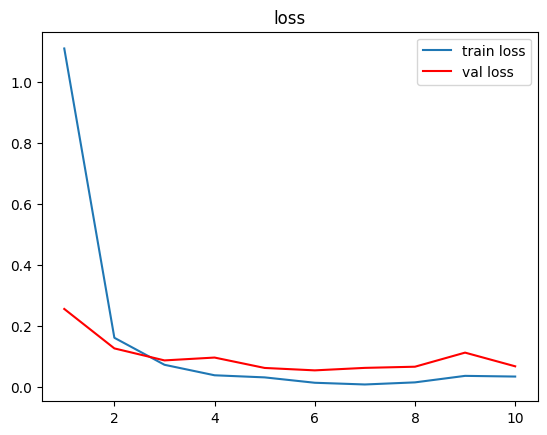

In [15]:
epochs = [i for i in range(1, len(h1.history['acc']) + 1)]
plt.plot(epochs, h1.history['loss'], label='train loss')
plt.plot(epochs, h1.history['val_loss'], 'r', label='val loss')
plt.title('loss')
plt.legend()
plt.show()

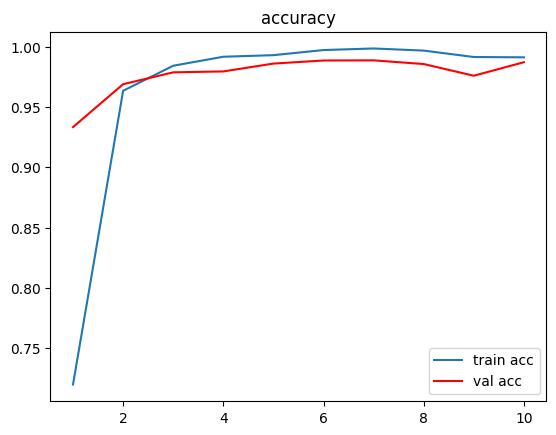

In [16]:
plt.plot(epochs, h1.history['acc'], label='train acc')
plt.plot(epochs, h1.history['val_acc'], 'r', label='val acc')
plt.title('accuracy')
plt.legend()
plt.show()

첫번째 모델의 과대적합을 해결하기 위해 dropout을 추가하여 학습해보자

In [17]:
def model2(input_shape=(32, 32, 3)):
    tf.random.set_seed(8)
    model = tf.keras.models.Sequential([
        tf.keras.layers.Input(shape=input_shape),
        tf.keras.layers.Conv2D(filters=32, kernel_size=(5,5), strides=(1,1),
                            kernel_initializer=tf.keras.initializers.glorot_uniform()),
        tf.keras.layers.MaxPooling2D((2,2)),
        tf.keras.layers.Dropout(0.2),
        tf.keras.layers.Conv2D(filters=64, kernel_size=(5,5), strides=(1,1),
                            kernel_initializer=tf.keras.initializers.glorot_uniform()),
        tf.keras.layers.MaxPooling2D((2,2)),
        tf.keras.layers.Dropout(0.2),
        tf.keras.layers.Flatten(),
        tf.keras.layers.Dense(1024, activation='relu',
                            kernel_initializer=tf.keras.initializers.glorot_uniform()),
        tf.keras.layers.Dropout(0.4),
        tf.keras.layers.Dense(N_CLASSES, activation='softmax',
                            kernel_initializer=tf.keras.initializers.glorot_uniform())
    ])
    
    model.summary()
    return model

최적화 알고리즘으로 adam의 학습률을 0.001로 두고 batch_size를 256, 에포크를 10으로 두고학습하였다.

In [18]:
m2 = model2()
m2.compile(optimizer=tf.keras.optimizers.Adam(0.001),
        loss='categorical_crossentropy',
        metrics=['acc'])
h2 = m2.fit(X_train, y_train, batch_size=256, epochs=10, validation_data=(X_val, y_val))


Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_2 (Conv2D)           (None, 28, 28, 32)        2432      
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 14, 14, 32)       0         
 2D)                                                             
                                                                 
 dropout (Dropout)           (None, 14, 14, 32)        0         
                                                                 
 conv2d_3 (Conv2D)           (None, 10, 10, 64)        51264     
                                                                 
 max_pooling2d_3 (MaxPooling  (None, 5, 5, 64)         0         
 2D)                                                             
                                                                 
 dropout_1 (Dropout)         (None, 5, 5, 64)         

검증세트의 정확도는 더 좋아졌으나 사실 과대적합이 완벽하게 해결된것 같지는 않은 결과이다.

In [19]:
m2.evaluate(X_val, y_val)


246/246 [==============================] - 2s 8ms/step - loss: 0.0512 - acc: 0.9895


[0.05115392431616783, 0.9895434975624084]

In [36]:
from sklearn.metrics import classification_report

y_val_pred = m2.predict(X_val)
y_val_pred_classified = np.argmax(y_val_pred, axis=1).astype(np.int32)
y_val_true_classified = np.argmax(y_val, axis=1).astype(np.int32)
print(classification_report(y_val_true_classified, y_val_pred_classified))

246/246 [==============================] - 2s 8ms/step
              precision    recall  f1-score   support

           0       0.98      0.98      0.98        51
           1       0.98      1.00      0.99       426
           2       1.00      0.98      0.99       456
           3       0.99      0.98      0.99       294
           4       1.00      1.00      1.00       412
           5       0.99      0.98      0.98       380
           6       0.99      1.00      0.99        80
           7       0.99      0.99      0.99       284
           8       1.00      0.99      1.00       284
           9       1.00      1.00      1.00       324
          10       0.99      0.99      0.99       402
          11       0.95      0.99      0.97       268
          12       0.99      1.00      1.00       435
          13       0.99      0.99      0.99       428
          14       0.99      0.99      0.99       176
          15       1.00      0.98      0.99       132
          16       1.00   

에포크수를 조금 줄여서 학습해보자

In [39]:
m2_1 = model2()
m2_1.compile(optimizer=tf.keras.optimizers.Adam(0.001),
        loss='categorical_crossentropy',
        metrics=['acc'])
h2_1 = m2_1.fit(X_train, y_train, batch_size=256, epochs=5, validation_data=(X_val, y_val))

Model: "sequential_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_6 (Conv2D)           (None, 28, 28, 32)        2432      
                                                                 
 max_pooling2d_6 (MaxPooling  (None, 14, 14, 32)       0         
 2D)                                                             
                                                                 
 dropout_11 (Dropout)        (None, 14, 14, 32)        0         
                                                                 
 conv2d_7 (Conv2D)           (None, 10, 10, 64)        51264     
                                                                 
 max_pooling2d_7 (MaxPooling  (None, 5, 5, 64)         0         
 2D)                                                             
                                                                 
 dropout_12 (Dropout)        (None, 5, 5, 64)         

에포크를 줄여도 과대적합은 해결된거같지않다 학습률을 한번 조정해보자

In [40]:
m2_2 = model2()
m2_2.compile(optimizer=tf.keras.optimizers.Adam(0.01),
        loss='categorical_crossentropy',
        metrics=['acc'])
h2_2 = m2.fit(X_train, y_train, batch_size=256, epochs=6, validation_data=(X_val, y_val))

Model: "sequential_8"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_8 (Conv2D)           (None, 28, 28, 32)        2432      
                                                                 
 max_pooling2d_8 (MaxPooling  (None, 14, 14, 32)       0         
 2D)                                                             
                                                                 
 dropout_14 (Dropout)        (None, 14, 14, 32)        0         
                                                                 
 conv2d_9 (Conv2D)           (None, 10, 10, 64)        51264     
                                                                 
 max_pooling2d_9 (MaxPooling  (None, 5, 5, 64)         0         
 2D)                                                             
                                                                 
 dropout_15 (Dropout)        (None, 5, 5, 64)         

In [41]:
m2_3 = model2()
m2_3.compile(optimizer=tf.keras.optimizers.Adam(0.0001),
        loss='categorical_crossentropy',
        metrics=['acc'])
h2_3 = m2.fit(X_train, y_train, batch_size=256, epochs=6, validation_data=(X_val, y_val))

Model: "sequential_9"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_10 (Conv2D)          (None, 28, 28, 32)        2432      
                                                                 
 max_pooling2d_10 (MaxPoolin  (None, 14, 14, 32)       0         
 g2D)                                                            
                                                                 
 dropout_17 (Dropout)        (None, 14, 14, 32)        0         
                                                                 
 conv2d_11 (Conv2D)          (None, 10, 10, 64)        51264     
                                                                 
 max_pooling2d_11 (MaxPoolin  (None, 5, 5, 64)         0         
 g2D)                                                            
                                                                 
 dropout_18 (Dropout)        (None, 5, 5, 64)         

이미지 분류용 알고리즘에 좋다고 하는 VGG16로 학습해보자

In [20]:
VGG16_base = tf.keras.applications.VGG16(weights='imagenet', include_top=False, input_shape=(32,32,3))
VGG16_base.summary()

Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 32, 32, 3)]       0         
                                                                 
 block1_conv1 (Conv2D)       (None, 32, 32, 64)        1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 32, 32, 64)        36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 16, 16, 64)        0         
                                                                 
 block2_conv1 (Conv2D)       (None, 16, 16, 128)       73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 16, 16, 128)       147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 8, 8, 128)         0     

우선 VGG16 모델 이후의 Dense layer를 쌓아서 확장해보도록 하겠습니다. VGG16 모델의 output이 (1,1,512)이기 때문에 확장할 layer의 처음 input은 (1,1,512)가 됩니다.

그리고 입력으로 사용되는 feature들은 VGG16의 output이기 때문에 FC layer들의 입력으로 사용될 feature들을 먼저 구하고 그 output을 입력으로 FC layer를 학습합니다.

In [21]:
def FC_model():
    tf.random.set_seed(8)
    model = tf.keras.models.Sequential([
        tf.keras.layers.Flatten(input_shape=(1,1,512)),
        tf.keras.layers.Dense(512, activation='relu',
                            kernel_initializer=tf.keras.initializers.glorot_uniform()),
        tf.keras.layers.Dropout(0.4),
        tf.keras.layers.Dense(N_CLASSES, activation='sigmoid')
    ])
    
    model.compile(optimizer=tf.keras.optimizers.Adam(0.001),
                loss='categorical_crossentropy',
                metrics=['acc'])
    model.summary()
    return model

m3 = FC_model()

feature_train = VGG16_base.predict(X_train)
feature_val = VGG16_base.predict(X_val)
feature_test = VGG16_base.predict(X_val)

m3.fit(feature_train, y_train, batch_size=256, epochs=10, validation_data=(feature_val, y_val))


Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten_2 (Flatten)         (None, 512)               0         
                                                                 
 dense_4 (Dense)             (None, 512)               262656    
                                                                 
 dropout_3 (Dropout)         (None, 512)               0         
                                                                 
 dense_5 (Dense)             (None, 43)                22059     
                                                                 
Total params: 284,715
Trainable params: 284,715
Non-trainable params: 0
_________________________________________________________________
246/246 [==============================] - 29s 116ms/step
Epoch 1/10
123/123 [==============================] - 1s 8ms/step - loss: 2.2969 - acc: 0.3459 - val_loss: 1.6668 - val_ac

In [22]:
tf.random.set_seed(8)
VGG16_model = tf.keras.models.Sequential([
    VGG16_base,
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(512, activation='relu',
                        kernel_initializer=tf.keras.initializers.glorot_uniform()),
    tf.keras.layers.Dropout(0.4),
    tf.keras.layers.Dense(N_CLASSES, activation='softmax',
                        kernel_initializer=tf.keras.initializers.glorot_uniform())
])

VGG16_model.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg16 (Functional)          (None, 1, 1, 512)         14714688  
                                                                 
 flatten_3 (Flatten)         (None, 512)               0         
                                                                 
 dense_6 (Dense)             (None, 512)               262656    
                                                                 
 dropout_4 (Dropout)         (None, 512)               0         
                                                                 
 dense_7 (Dense)             (None, 43)                22059     
                                                                 
Total params: 14,999,403
Trainable params: 14,999,403
Non-trainable params: 0
_________________________________________________________________


In [23]:
VGG16_base.trainable = True
 
set_trainable = False
for layer in VGG16_base.layers:
    if layer.name == 'block5_conv1':
        set_trainable = True
    if set_trainable:
        layer.trainable = True
    else:
        layer.trainable = False
 
print('훈련되는 가중치의 수:', len(VGG16_model.trainable_weights))


훈련되는 가중치의 수: 10


In [24]:
VGG16_model.compile(optimizer=tf.keras.optimizers.Adam(0.001),
                loss='categorical_crossentropy',
                metrics=['acc'])
history = VGG16_model.fit(X_train, y_train, batch_size=256, epochs=10, validation_data=(X_val, y_val))


Epoch 1/10
123/123 [==============================] - 382s 3s/step - loss: 1.6815 - acc: 0.4771 - val_loss: 0.8795 - val_acc: 0.6988
Epoch 2/10
123/123 [==============================] - 407s 3s/step - loss: 0.6782 - acc: 0.7696 - val_loss: 0.4535 - val_acc: 0.8484
Epoch 3/10
123/123 [==============================] - 397s 3s/step - loss: 0.3916 - acc: 0.8653 - val_loss: 0.3570 - val_acc: 0.8812
Epoch 4/10
123/123 [==============================] - 389s 3s/step - loss: 0.2819 - acc: 0.9056 - val_loss: 0.2852 - val_acc: 0.9079
Epoch 5/10
123/123 [==============================] - 382s 3s/step - loss: 0.1945 - acc: 0.9354 - val_loss: 0.2412 - val_acc: 0.9226
Epoch 6/10
123/123 [==============================] - 391s 3s/step - loss: 0.1530 - acc: 0.9491 - val_loss: 0.2231 - val_acc: 0.9353
Epoch 7/10
123/123 [==============================] - 385s 3s/step - loss: 0.1413 - acc: 0.9542 - val_loss: 0.2301 - val_acc: 0.9348
Epoch 8/10
123/123 [==============================] - 383s 3s/step - 

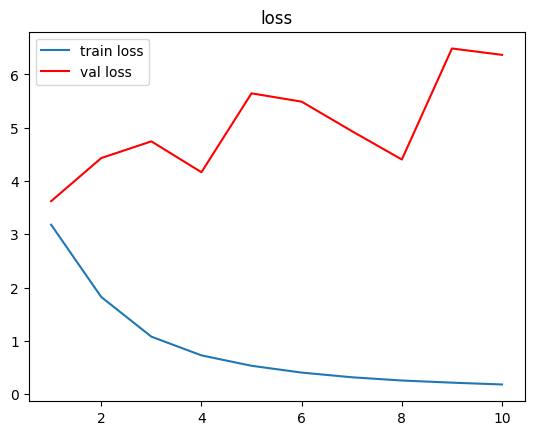

In [44]:
epochs = [i for i in range(1, len(h1.history['acc']) + 1)]
plt.plot(epochs, history.history['loss'], label='train loss')
plt.plot(epochs, history.history['val_loss'], 'r', label='val loss')
plt.title('loss')
plt.legend()
plt.show()

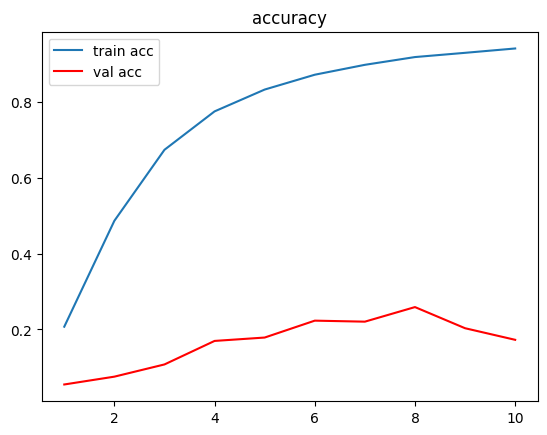

In [45]:
plt.plot(epochs, history.history['acc'], label='train acc')
plt.plot(epochs, history.history['val_acc'], 'r', label='val acc')
plt.title('accuracy')
plt.legend()
plt.show()

In [25]:
VGG16_model.evaluate(X_val, y_val)


246/246 [==============================] - 33s 134ms/step - loss: 0.1901 - acc: 0.9420


[0.1901271641254425, 0.9419791102409363]

In [37]:
from sklearn.metrics import classification_report

y_val_pred = VGG16_model.predict(X_val)
y_val_pred_classified = np.argmax(y_val_pred, axis=1).astype(np.int32)
y_val_true_classified = np.argmax(y_val, axis=1).astype(np.int32)
print(classification_report(y_val_true_classified, y_val_pred_classified))

246/246 [==============================] - 27s 110ms/step
              precision    recall  f1-score   support

           0       0.98      0.98      0.98        51
           1       0.98      0.98      0.98       426
           2       0.98      0.98      0.98       456
           3       0.95      0.98      0.96       294
           4       0.98      0.96      0.97       412
           5       0.97      0.96      0.96       380
           6       1.00      1.00      1.00        80
           7       0.97      0.99      0.98       284
           8       0.97      0.97      0.97       284
           9       1.00      1.00      1.00       324
          10       1.00      0.99      1.00       402
          11       0.97      0.98      0.98       268
          12       1.00      1.00      1.00       435
          13       1.00      1.00      1.00       428
          14       1.00      1.00      1.00       176
          15       1.00      1.00      1.00       132
          16       1.00

In [26]:
history_2 = VGG16_model.fit(X_train, y_train, batch_size=256, epochs=10, validation_data=(X_val, y_val))


Epoch 1/10
123/123 [==============================] - 391s 3s/step - loss: 0.0853 - acc: 0.9723 - val_loss: 0.1735 - val_acc: 0.9490
Epoch 2/10
123/123 [==============================] - 393s 3s/step - loss: 0.0869 - acc: 0.9718 - val_loss: 0.2366 - val_acc: 0.9313
Epoch 3/10
123/123 [==============================] - 390s 3s/step - loss: 0.0589 - acc: 0.9813 - val_loss: 0.1599 - val_acc: 0.9538
Epoch 4/10
123/123 [==============================] - 390s 3s/step - loss: 0.0685 - acc: 0.9782 - val_loss: 0.1283 - val_acc: 0.9651
Epoch 5/10
123/123 [==============================] - 391s 3s/step - loss: 0.0685 - acc: 0.9792 - val_loss: 0.2197 - val_acc: 0.9462
Epoch 6/10
123/123 [==============================] - 391s 3s/step - loss: 0.0730 - acc: 0.9773 - val_loss: 0.2103 - val_acc: 0.9463
Epoch 7/10
123/123 [==============================] - 392s 3s/step - loss: 0.0634 - acc: 0.9804 - val_loss: 0.1799 - val_acc: 0.9535
Epoch 8/10
123/123 [==============================] - 389s 3s/step - 

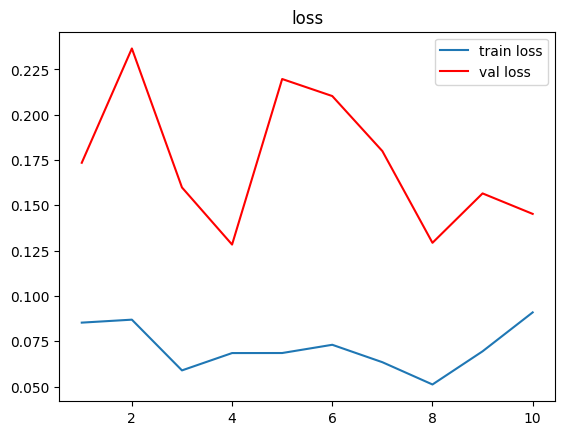

In [46]:
epochs = [i for i in range(1, len(h1.history['acc']) + 1)]
plt.plot(epochs, history_2.history['loss'], label='train loss')
plt.plot(epochs, history_2.history['val_loss'], 'r', label='val loss')
plt.title('loss')
plt.legend()
plt.show()

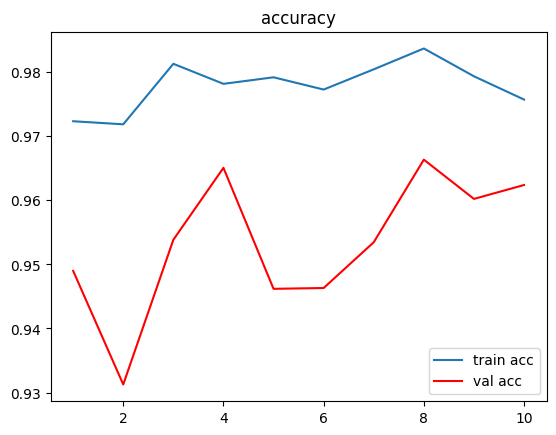

In [47]:
plt.plot(epochs, history_2.history['acc'], label='train acc')
plt.plot(epochs, history_2.history['val_acc'], 'r', label='val acc')
plt.title('accuracy')
plt.legend()
plt.show()

In [27]:
VGG16_model.compile(optimizer=tf.keras.optimizers.Adam(0.0001),
                loss='categorical_crossentropy',
                metrics=['acc'])
VGG16_model.fit(X_train, y_train, batch_size=256, epochs=10, validation_data=(X_val, y_val))
VGG16_model.evaluate(X_val, y_val)

Epoch 1/10
123/123 [==============================] - 391s 3s/step - loss: 0.0135 - acc: 0.9971 - val_loss: 0.0789 - val_acc: 0.9811
Epoch 2/10
123/123 [==============================] - 391s 3s/step - loss: 0.0029 - acc: 0.9994 - val_loss: 0.0800 - val_acc: 0.9816
Epoch 3/10
123/123 [==============================] - 392s 3s/step - loss: 0.0015 - acc: 0.9997 - val_loss: 0.0782 - val_acc: 0.9820
Epoch 4/10
123/123 [==============================] - 393s 3s/step - loss: 9.2790e-04 - acc: 0.9997 - val_loss: 0.0823 - val_acc: 0.9832
Epoch 5/10
123/123 [==============================] - 391s 3s/step - loss: 0.0018 - acc: 0.9995 - val_loss: 0.0869 - val_acc: 0.9823
Epoch 6/10
123/123 [==============================] - 392s 3s/step - loss: 8.8947e-04 - acc: 0.9997 - val_loss: 0.0869 - val_acc: 0.9833
Epoch 7/10
123/123 [==============================] - 391s 3s/step - loss: 0.0026 - acc: 0.9992 - val_loss: 0.1014 - val_acc: 0.9805
Epoch 8/10
123/123 [==============================] - 389s 3s

[0.0840831771492958, 0.9848253130912781]

이번엔 ResNet50을 사용해보도록 하겠습니다.



In [28]:
ResNet_base = tf.keras.applications.ResNet50(include_top=False, weights='imagenet', input_shape=(32,32,3))
ResNet_base.summary()

94765736/94765736 [==============================] - 9s 0us/step
Model: "resnet50"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_4 (InputLayer)           [(None, 32, 32, 3)]  0           []                               
                                                                                                  
 conv1_pad (ZeroPadding2D)      (None, 38, 38, 3)    0           ['input_4[0][0]']                
                                                                                                  
 conv1_conv (Conv2D)            (None, 16, 16, 64)   9472        ['conv1_pad[0][0]']              
                                                                                                  
 conv1_bn (BatchNormalization)  (None, 16, 16, 64)   256         ['conv1_conv[0][0]']             
                          

In [29]:
def FC_model2():
    tf.random.set_seed(8)
    model = tf.keras.models.Sequential([
        tf.keras.layers.Flatten(input_shape=(1,1,2048)),
        tf.keras.layers.Dropout(0.4),
        tf.keras.layers.Dense(1024, activation='relu',
                            kernel_initializer=tf.keras.initializers.glorot_uniform()),
        tf.keras.layers.Dropout(0.4),
        tf.keras.layers.Dense(N_CLASSES, activation='sigmoid',
                            kernel_initializer=tf.keras.initializers.glorot_uniform())
    ])
    
    model.compile(optimizer=tf.keras.optimizers.Adam(0.001),
                loss='categorical_crossentropy',
                metrics=['acc'])
    model.summary()
    return model

m4 = FC_model2()

feature_train = ResNet_base.predict(X_train)
feature_val = ResNet_base.predict(X_val)
feature_test = ResNet_base.predict(X_val)

m4.fit(feature_train, y_train, batch_size=256, epochs=10, validation_data=(feature_val, y_val))


Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten_4 (Flatten)         (None, 2048)              0         
                                                                 
 dropout_5 (Dropout)         (None, 2048)              0         
                                                                 
 dense_8 (Dense)             (None, 1024)              2098176   
                                                                 
 dropout_6 (Dropout)         (None, 1024)              0         
                                                                 
 dense_9 (Dense)             (None, 43)                44075     
                                                                 
Total params: 2,142,251
Trainable params: 2,142,251
Non-trainable params: 0
_________________________________________________________________
246/246 [==============================] - 1

In [30]:
tf.random.set_seed(7)
ResNet_model = tf.keras.models.Sequential([
    ResNet_base,
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(1024, activation='relu',
                        kernel_initializer=tf.keras.initializers.glorot_uniform()),
    tf.keras.layers.Dropout(0.4),
    tf.keras.layers.Dense(N_CLASSES, activation='sigmoid',
                        kernel_initializer=tf.keras.initializers.glorot_uniform())
])
ResNet_model.summary()
 
ResNet_base.trainable = True
 
set_trainable = False
for layer in ResNet_base.layers:
    if layer.name == 'conv5_block1_1_conv':
        set_trainable = True
    if set_trainable:
        layer.trainable = True
    else:
        layer.trainable = False
 
print('훈련되는 가중치의 수:', len(ResNet_model.trainable_weights))


Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resnet50 (Functional)       (None, 1, 1, 2048)        23587712  
                                                                 
 flatten_5 (Flatten)         (None, 2048)              0         
                                                                 
 dense_10 (Dense)            (None, 1024)              2098176   
                                                                 
 dropout_7 (Dropout)         (None, 1024)              0         
                                                                 
 dense_11 (Dense)            (None, 43)                44075     
                                                                 
Total params: 25,729,963
Trainable params: 25,676,843
Non-trainable params: 53,120
_________________________________________________________________
훈련되는 가중치의 수: 44


In [31]:
ResNet_model.compile(optimizer=tf.keras.optimizers.Adam(0.0001),
                loss='categorical_crossentropy',
                metrics=['acc'])
history = ResNet_model.fit(X_train, y_train, batch_size=256, epochs=10, validation_data=(X_val, y_val))


Epoch 1/10
123/123 [==============================] - 691s 6s/step - loss: 3.1805 - acc: 0.2072 - val_loss: 3.6216 - val_acc: 0.0546
Epoch 2/10
123/123 [==============================] - 688s 6s/step - loss: 1.8249 - acc: 0.4869 - val_loss: 4.4308 - val_acc: 0.0752
Epoch 3/10
123/123 [==============================] - 694s 6s/step - loss: 1.0807 - acc: 0.6744 - val_loss: 4.7440 - val_acc: 0.1075
Epoch 4/10
123/123 [==============================] - 688s 6s/step - loss: 0.7295 - acc: 0.7758 - val_loss: 4.1654 - val_acc: 0.1696
Epoch 5/10
123/123 [==============================] - 688s 6s/step - loss: 0.5342 - acc: 0.8335 - val_loss: 5.6453 - val_acc: 0.1785
Epoch 6/10
123/123 [==============================] - 715s 6s/step - loss: 0.4065 - acc: 0.8727 - val_loss: 5.4888 - val_acc: 0.2232
Epoch 7/10
123/123 [==============================] - 686s 6s/step - loss: 0.3190 - acc: 0.8988 - val_loss: 4.9376 - val_acc: 0.2205
Epoch 8/10
123/123 [==============================] - 689s 6s/step - 

In [32]:
ResNet_model.evaluate(X_val, y_val)


246/246 [==============================] - 17s 71ms/step - loss: 6.3667 - acc: 0.1725


[6.366720199584961, 0.17253251373767853]